In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
import warnings

warnings.simplefilter("ignore")
import random
import scipy
from aging.plotting import (
    format_plots,
    PlotConfig,
    save_factory,
    figure,
    legend,
    format_pizza_plots,
)
from sklearn.linear_model import ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "wheel", tight_layout=False)

In [3]:
path = Path(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_05/wheel_merged.parquet"
)
df = pd.read_parquet(path)

In [4]:
col = [
    "age",
    "mouse",
    "cage",
    "uuid",
    "subject_name",
    "date",
    "rotations",
    "cum_rotations_x",
    "cum_rotations_y",
    "exp",
]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
df_male = pd.read_parquet(path)

In [6]:
## update data
# def remove_crl(df):
#     max=39
#     #x = df.filter(regex=r'\d')
#     syll=(['47','48','49','50'])
#     df.drop(syll,axis=1, inplace=True)
#     #df.drop('m05_c02_b01_s01', level=1, axis=0, inplace=True)
#     #df.drop('a85e0616-6a5b-4dd8-a2d6-51701084c25e',level=3, axis=0, inplace=True)
#     df.drop('b365ea6a-369f-4991-b139-15694dc1c86d',level=3, axis=0, inplace=True)
#     df.drop_duplicates()
#     return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
def remove_crl(df):
    return df[~df.index.get_level_values("session_name").str.contains("CRL")]

In [8]:
df_male = remove_crl(df_male)

In [9]:
# pseudo regression
mdl = KNeighborsRegressor(n_neighbors=10)
y = df_male['pseudotime_rank']
x = df_male.filter(regex=r'\d')
mdl.fit(x, y)
print(mdl.score(x, y))

0.9889124521359962


In [10]:
# apply to wheel data
#x = df.drop(['age', 'mouse', 'cage', 'uuid', 'subject_name', 'date','rotations',
#       'cum_rotations_x', 'cum_rotations_y', 'exp'],axis=1)
#x= df.to_numpy()
x = df.filter(regex=r'\d')
#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
df['psd']=mdl.predict(x.reindex(columns=df_male.filter(regex=r'\d').columns).fillna(0))

In [11]:
import math
#df['age_wk'] = df['age']//7
df['age_wk']=(df['age'] / 7).round().astype(int)

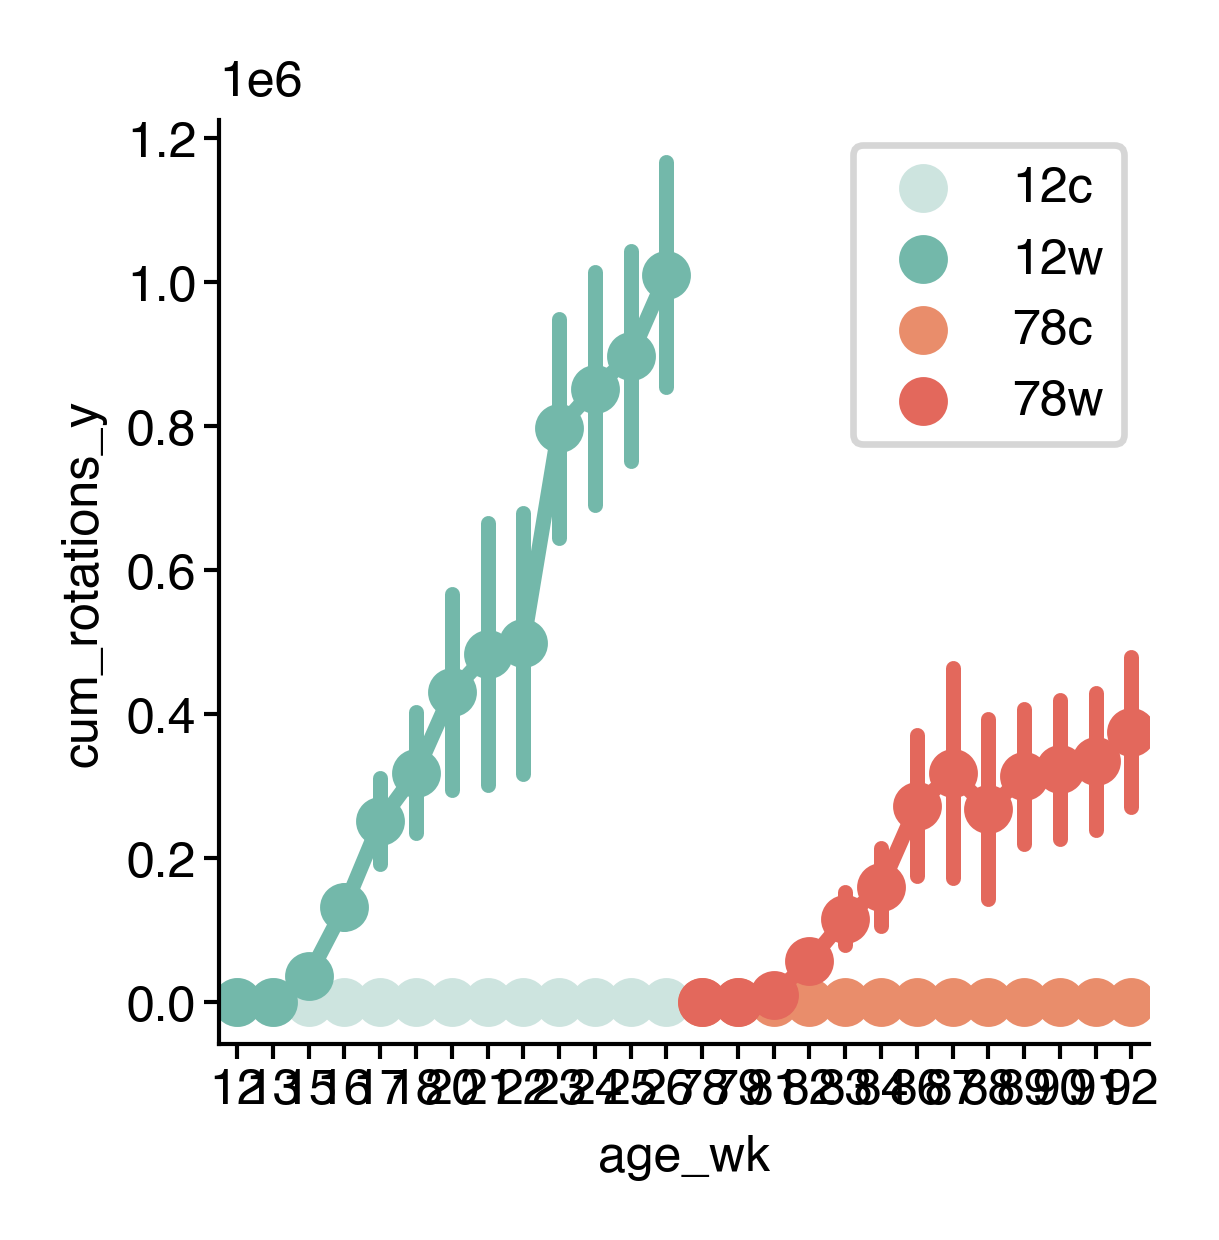

In [12]:
# plot scatter of pseudo time vs real time
figure(2,2)

sns.pointplot(
    data=df,
    x="age_wk",
    y="cum_rotations_y",
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    estimator='mean',
    errorbar='se',
    hue="exp")
legend=plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
sns.despine()

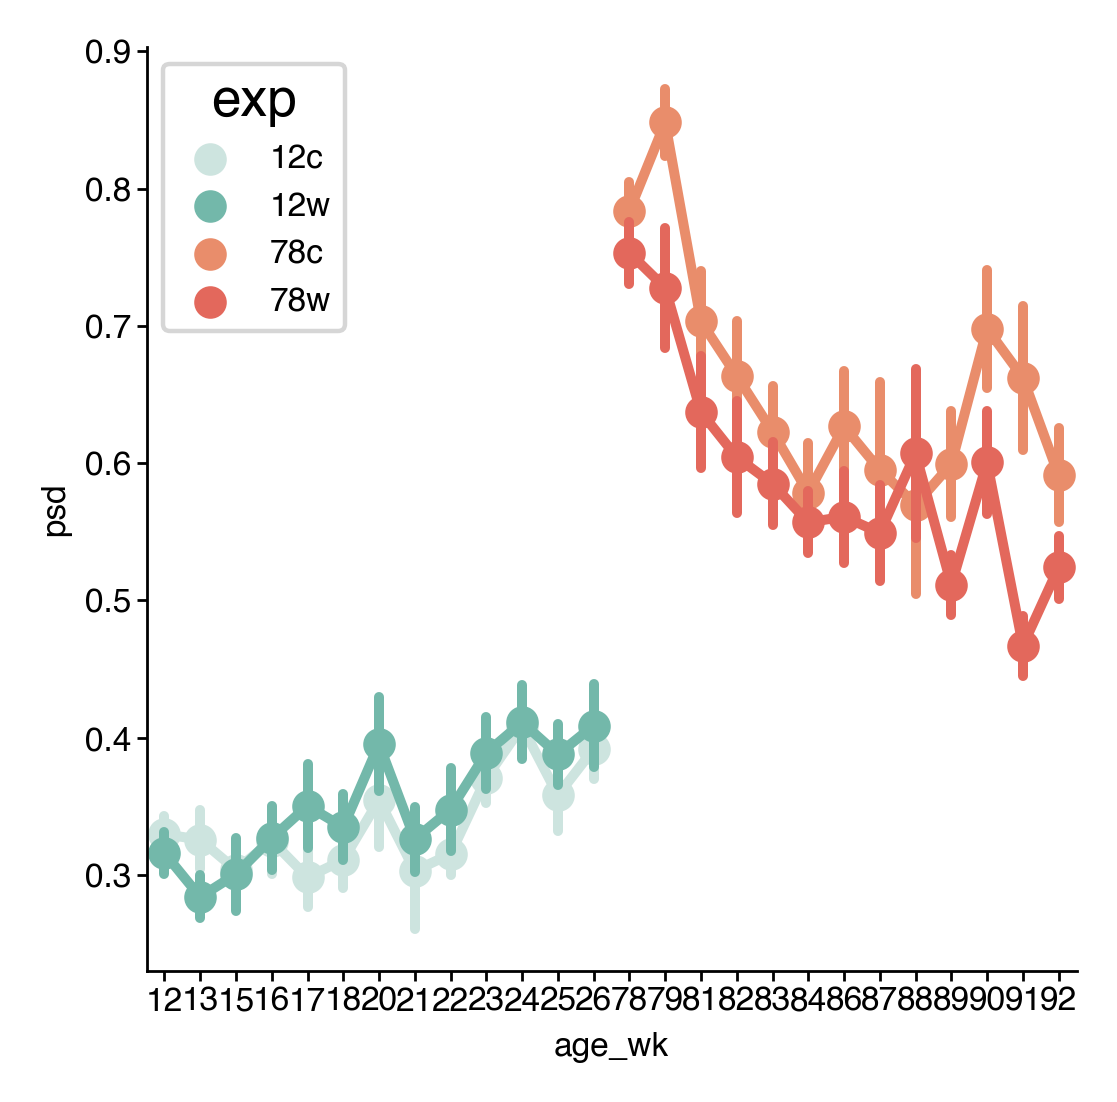

In [13]:
sns.pointplot(
    data=df,
    x="age_wk",
    y="psd",
    palette=["#cde4df", "#73b8aa", "#e98d6b", "#e3685c"],
    estimator="mean",
    errorbar="se",
    hue="exp",
)
sns.despine()

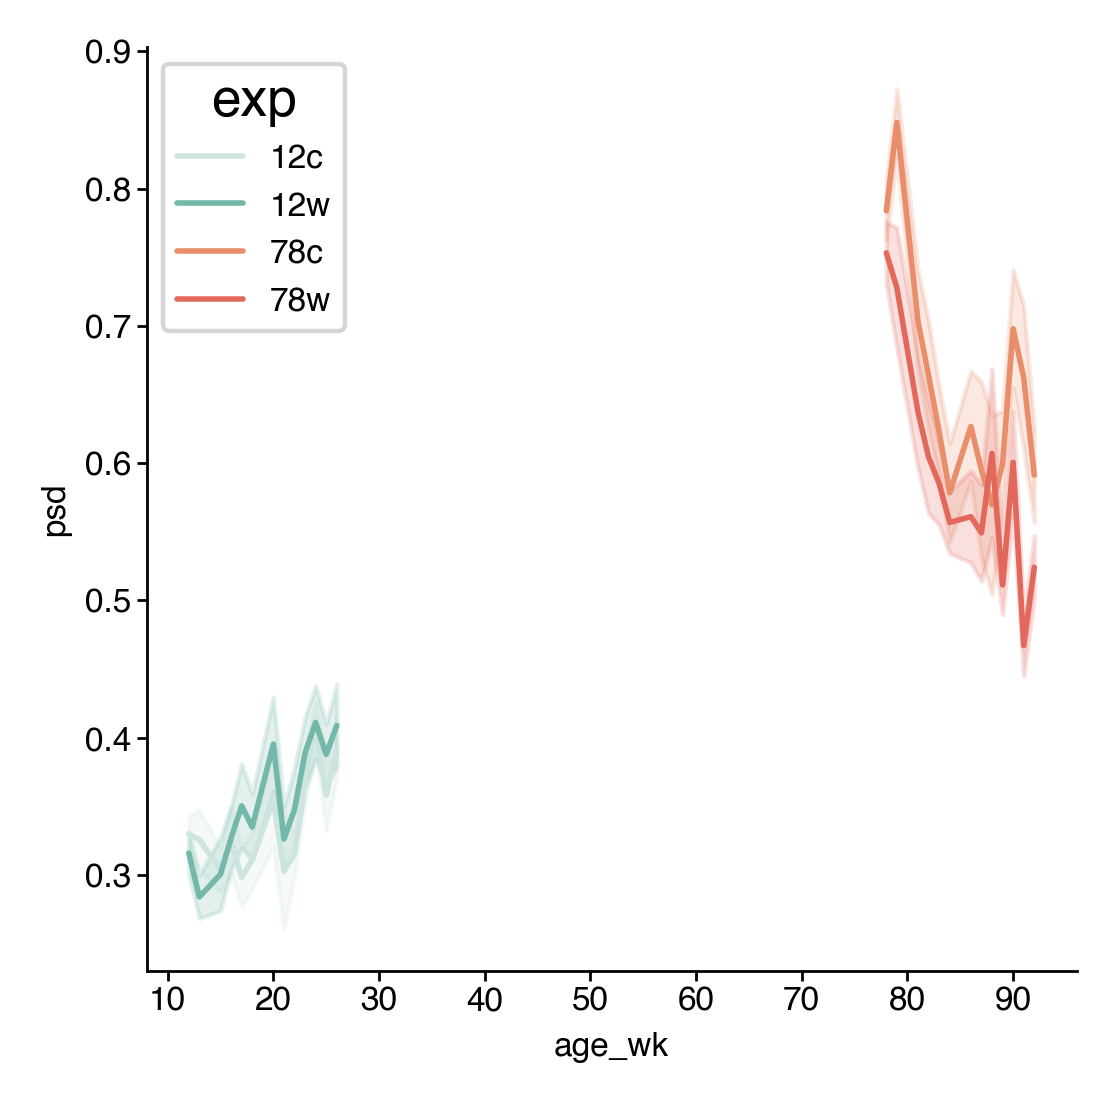

In [14]:
sns.lineplot(
    data=df,
    x="age_wk",
    y="psd",
    palette=["#cde4df", "#73b8aa", "#e98d6b", "#e3685c"],
    estimator="mean",
    errorbar="se",
    hue="exp",
)
sns.despine()

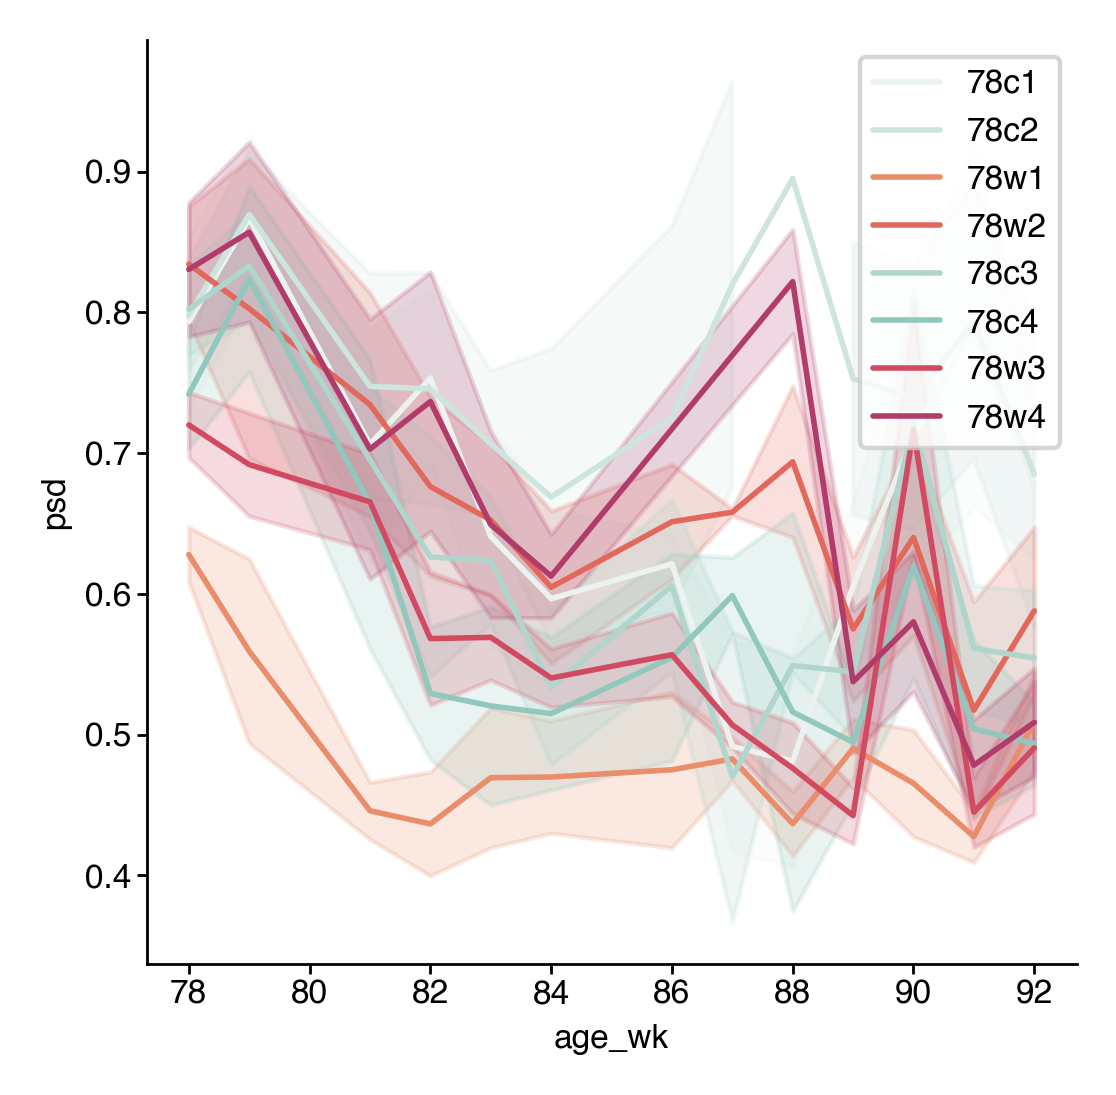

In [15]:
sns.lineplot(
    data=df.query("age_wk>60"),
    x="age_wk",
    y="psd",
    palette=[
        "#ebf2f0",
        "#cde4df",
        "#e98d6b",
        "#e3685c",
        "#afd5cd",
        "#91c7bc",
        "#d14a61",
        "#b13c6c",
    ],
    estimator="mean",
    errorbar="se",
    hue="cage",
)
legend = plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
sns.despine()

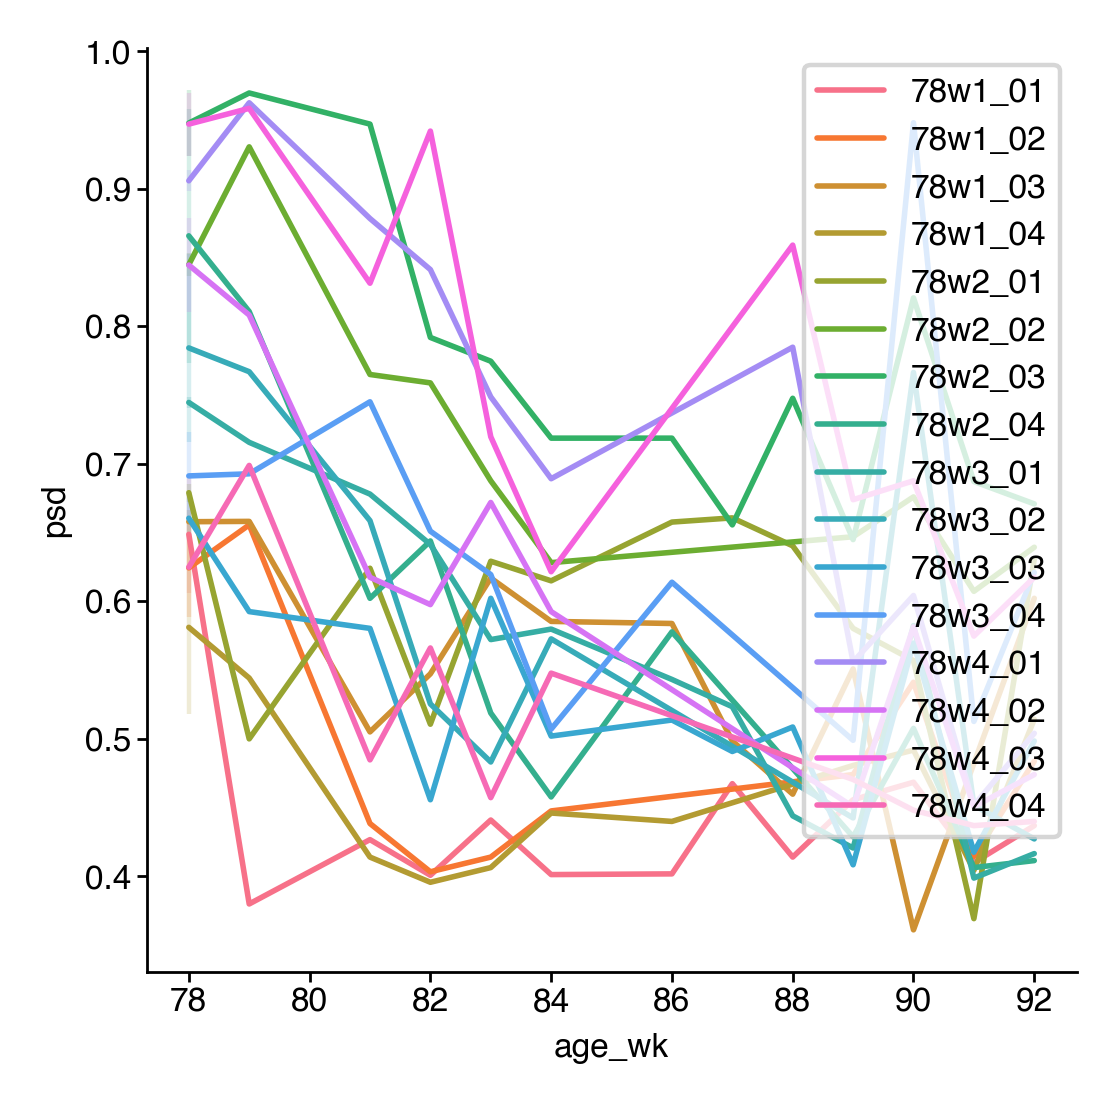

In [16]:
sns.lineplot(
    data=df.query(("age_wk>60 and exp=='78w'")),
    x="age_wk",
    y="psd",
    # palette = ['#ebf2f0', '#cde4df','#e98d6b', '#e3685c','#afd5cd', '#91c7bc','#d14a61', '#b13c6c'],
    estimator="mean",
    errorbar="se",
    hue="mouse",
)
legend = plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
sns.despine()

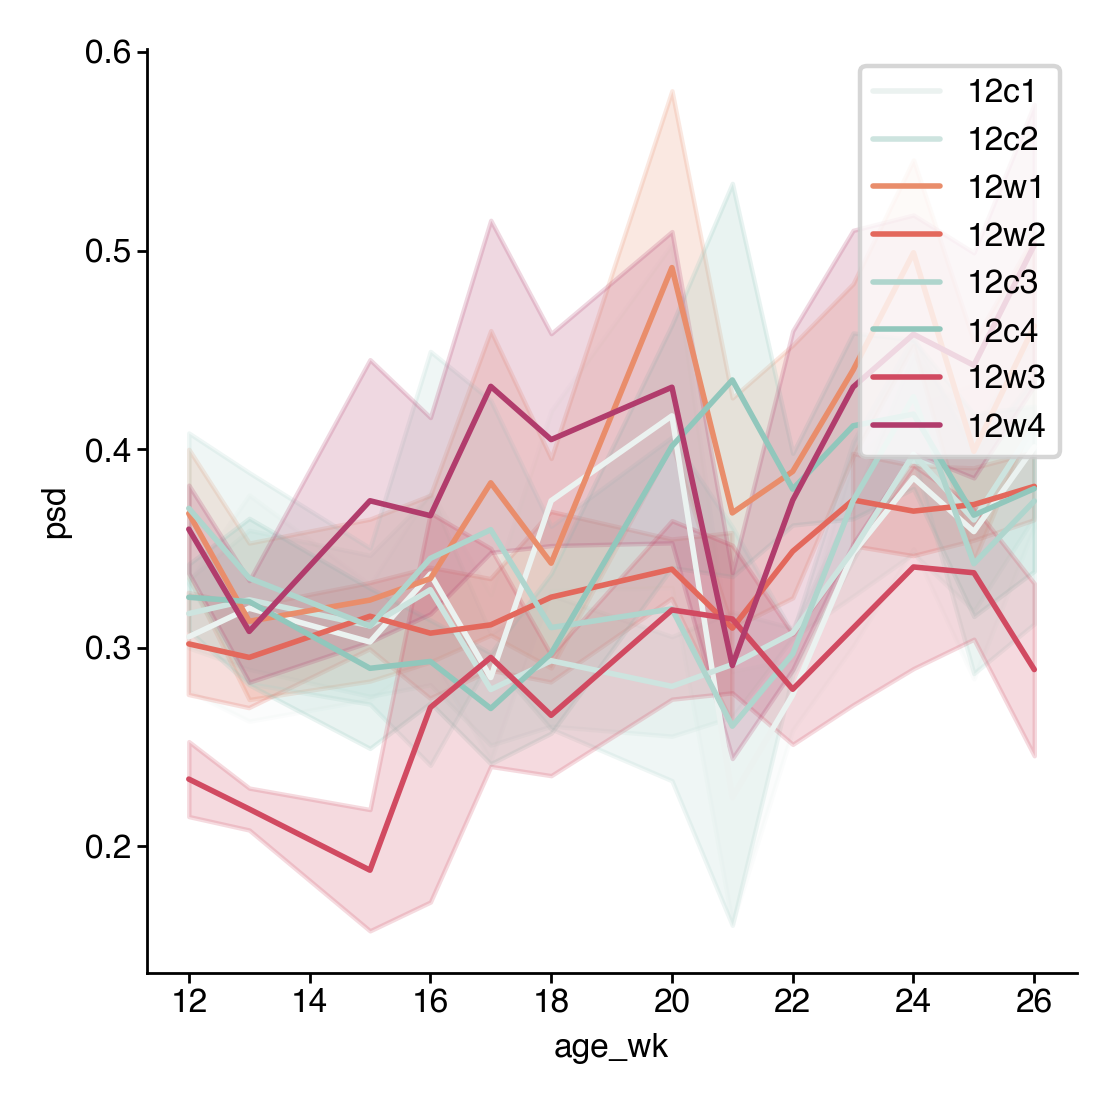

In [17]:
sns.lineplot(
    data=df.query("age_wk<60"),
    x="age_wk",
    y="psd",
    palette=[
        "#ebf2f0",
        "#cde4df",
        "#e98d6b",
        "#e3685c",
        "#afd5cd",
        "#91c7bc",
        "#d14a61",
        "#b13c6c",
    ],
    estimator="mean",
    errorbar="se",
    hue="cage",
)
legend = plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
sns.despine()

In [18]:
# calcualte absolute diff in psd between begining and end of exp
psd_diff = df.groupby(['mouse','cage','exp']).apply(lambda group: group.loc[group['age_wk'].idxmax()]['psd'] - group.loc[group['age_wk'].idxmin()]['psd'])
psd_diff = psd_diff.reset_index()
psd_diff.columns = ['mouse','cage','exp','diff']

In [19]:
# add total rotations
rotations = df.groupby(['mouse','cage','exp'])['cum_rotations_y'].max().to_numpy()
psd_diff['rotations']=rotations

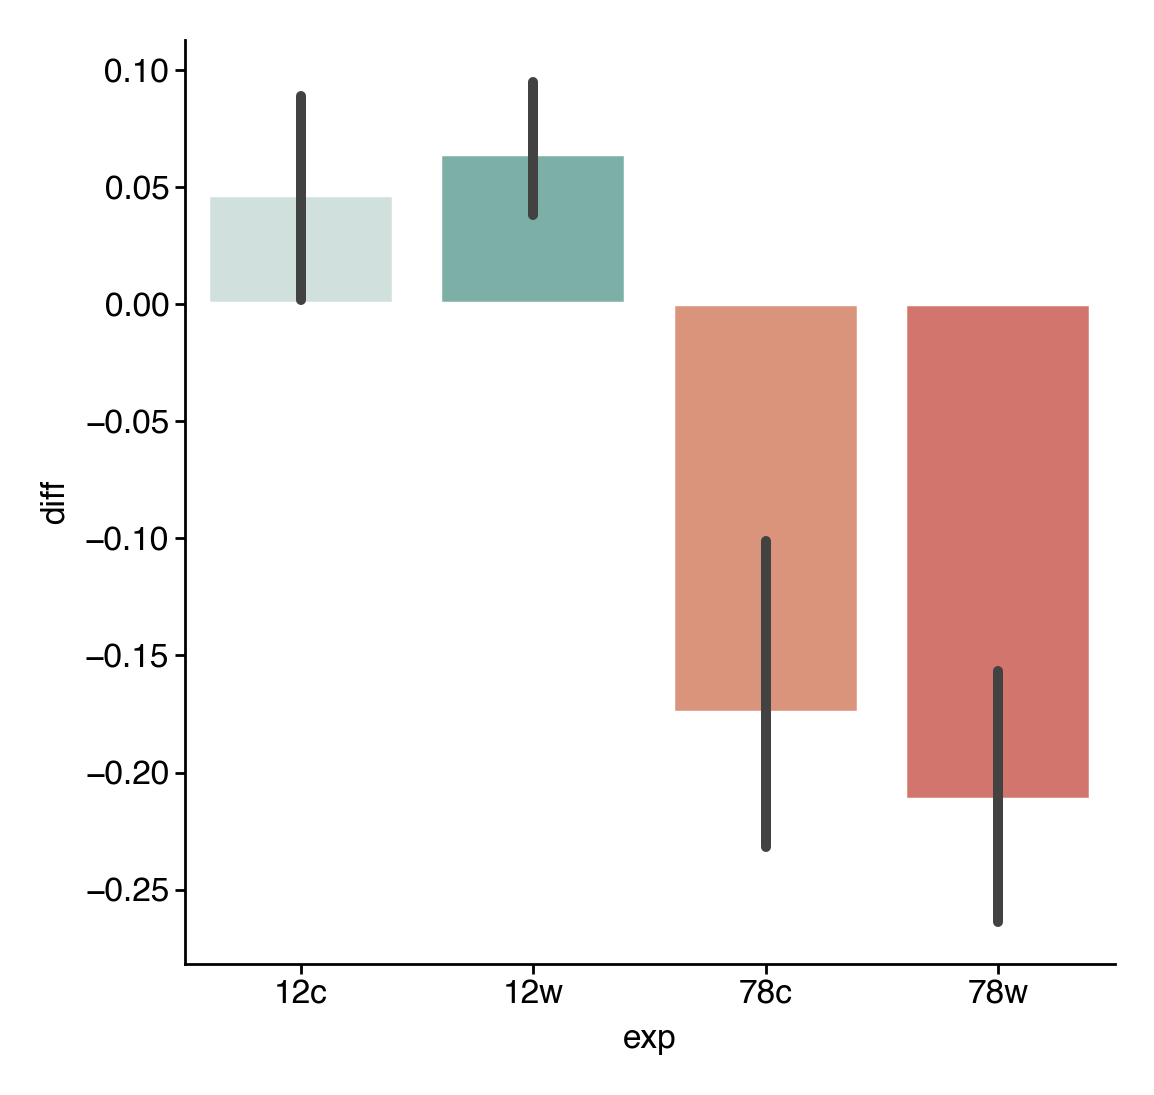

In [20]:
sns.barplot(
    data=psd_diff, 
    x="exp", 
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    y="diff")
sns.despine()

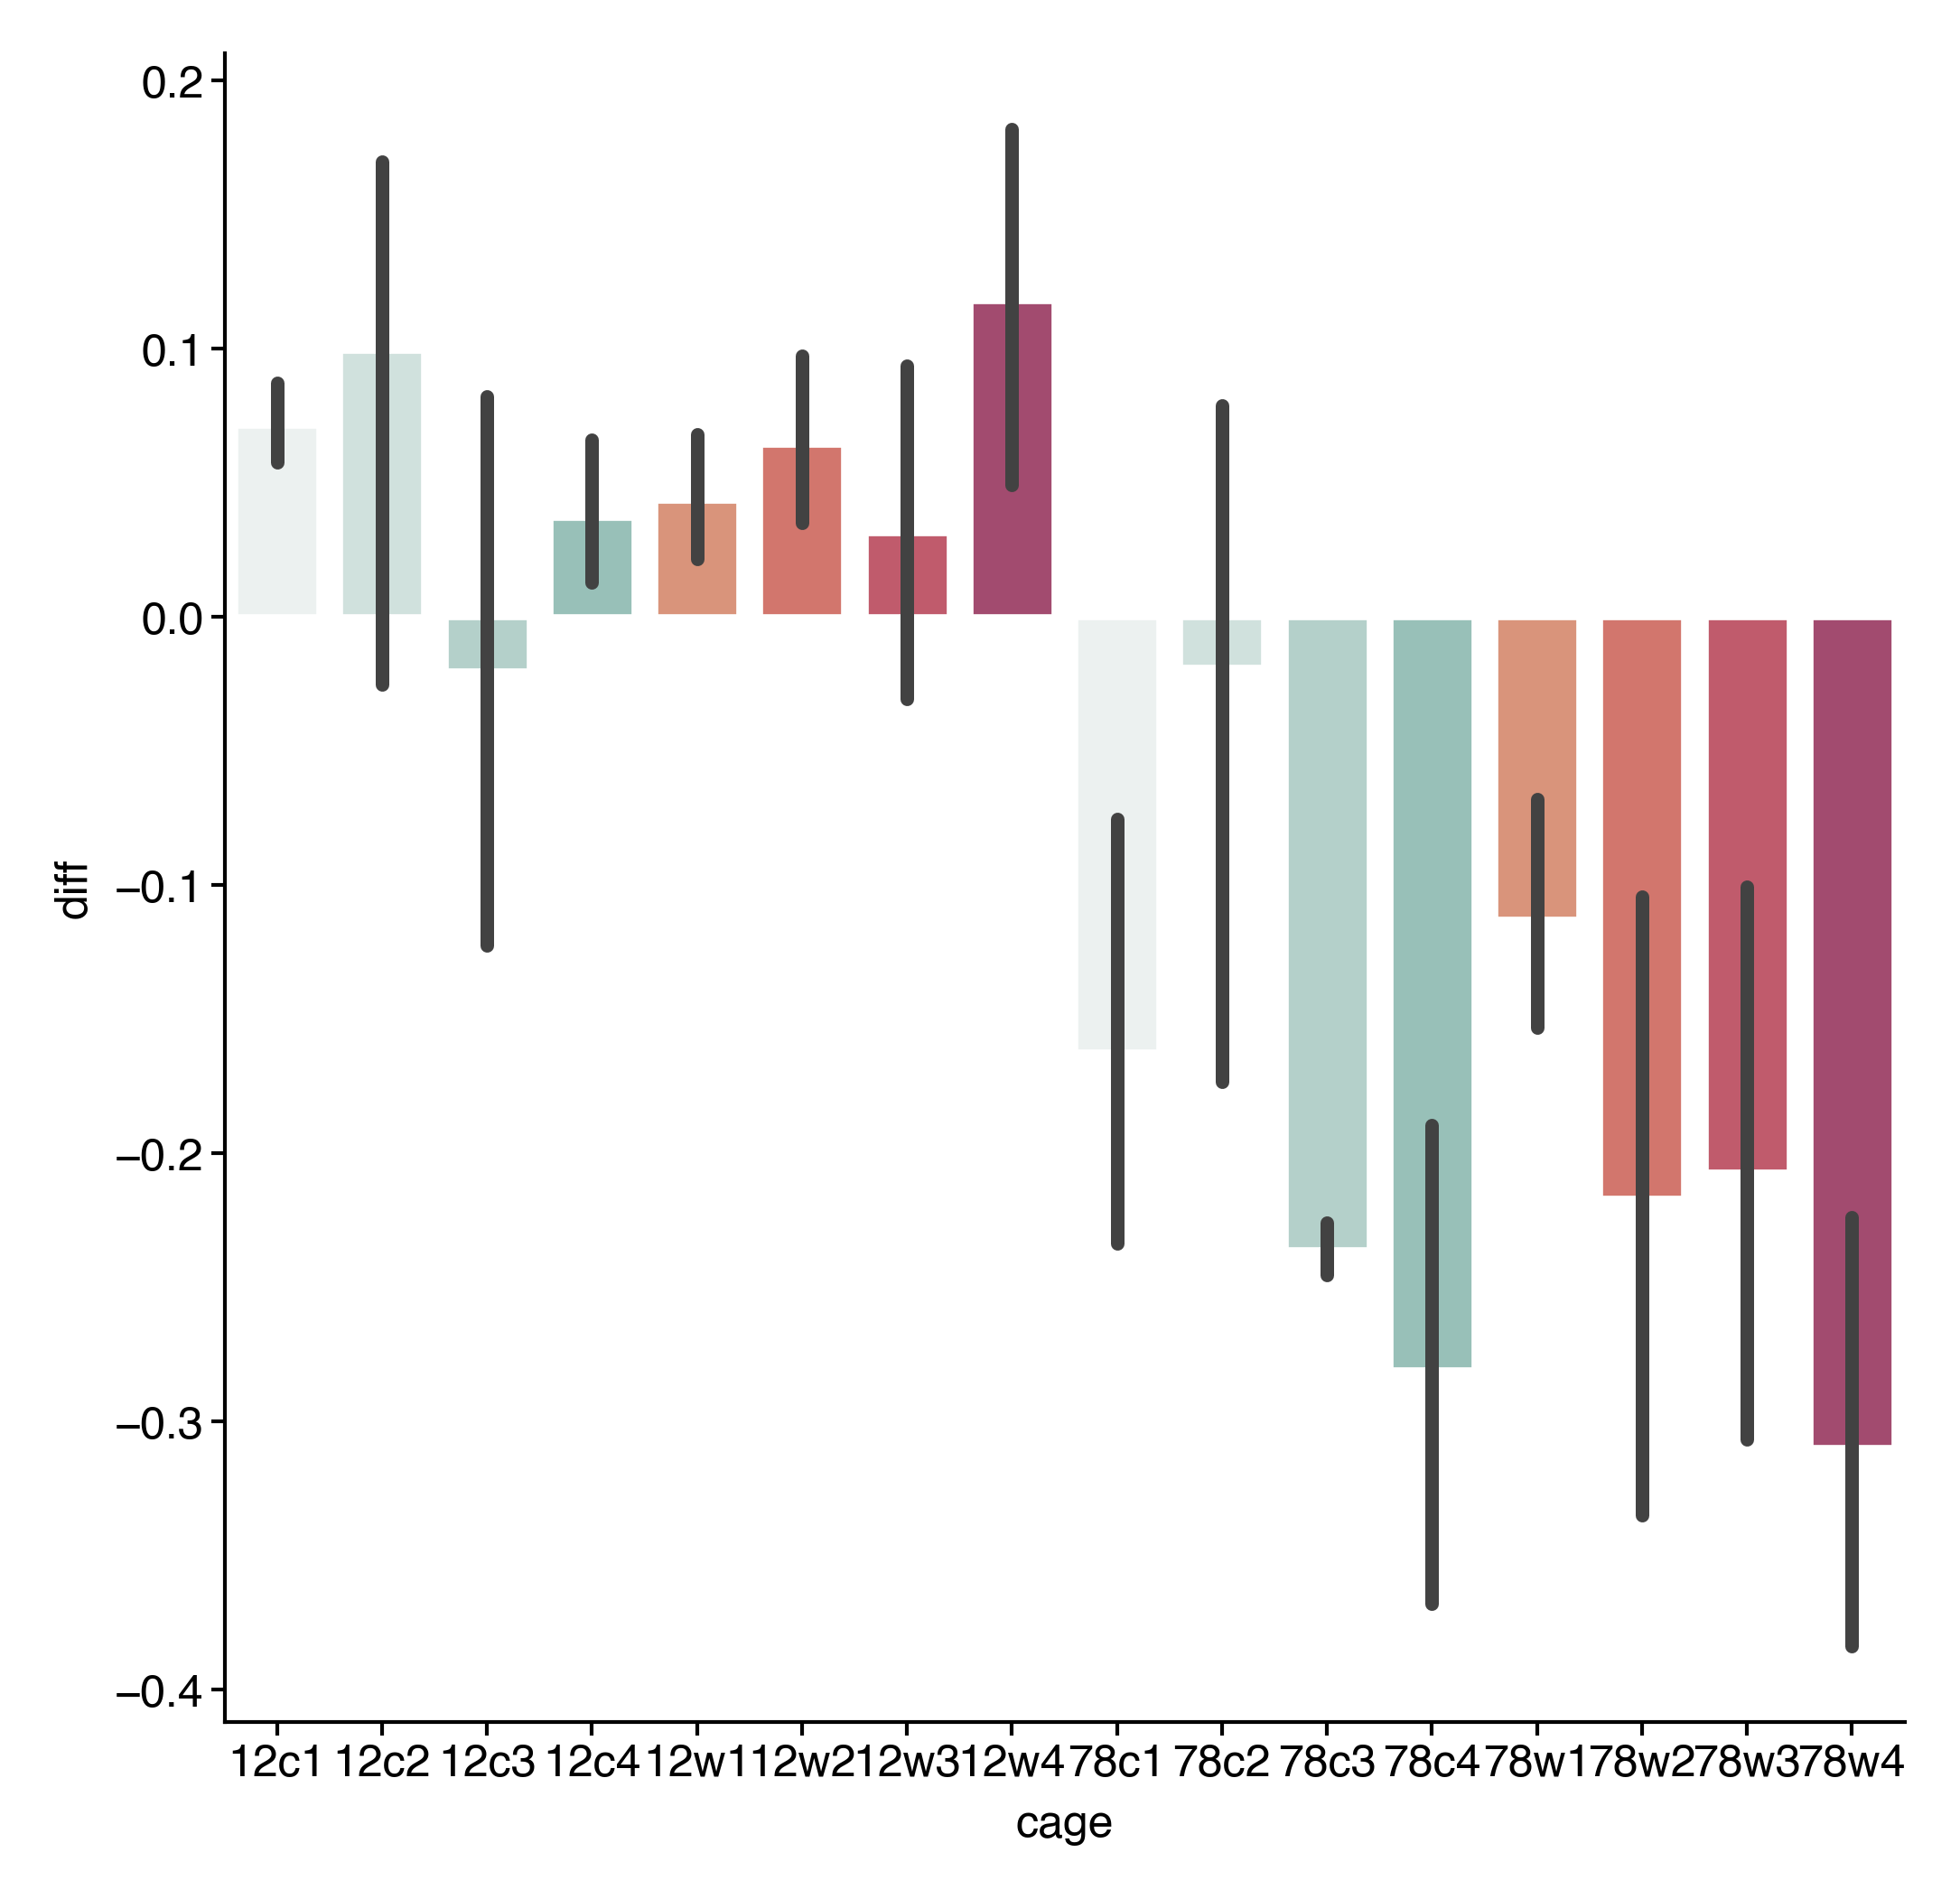

In [21]:
figure(4,4)
sns.barplot(
    data=psd_diff, 
    x="cage", 
    palette = ['#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c','#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c'],
    y="diff")
sns.despine()

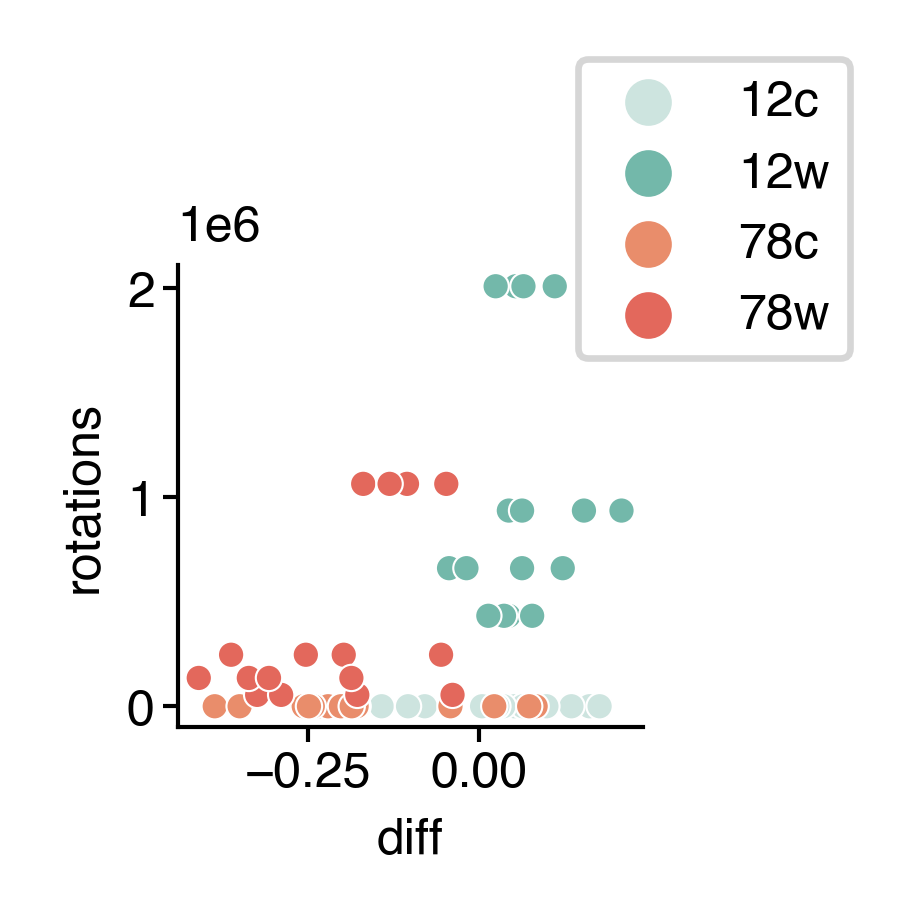

In [22]:
figure(1,1)
sns.scatterplot(
    data=psd_diff, 
    x='diff', 
    hue='exp',
    s=10,
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    y='rotations'
)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5))
sns.despine()

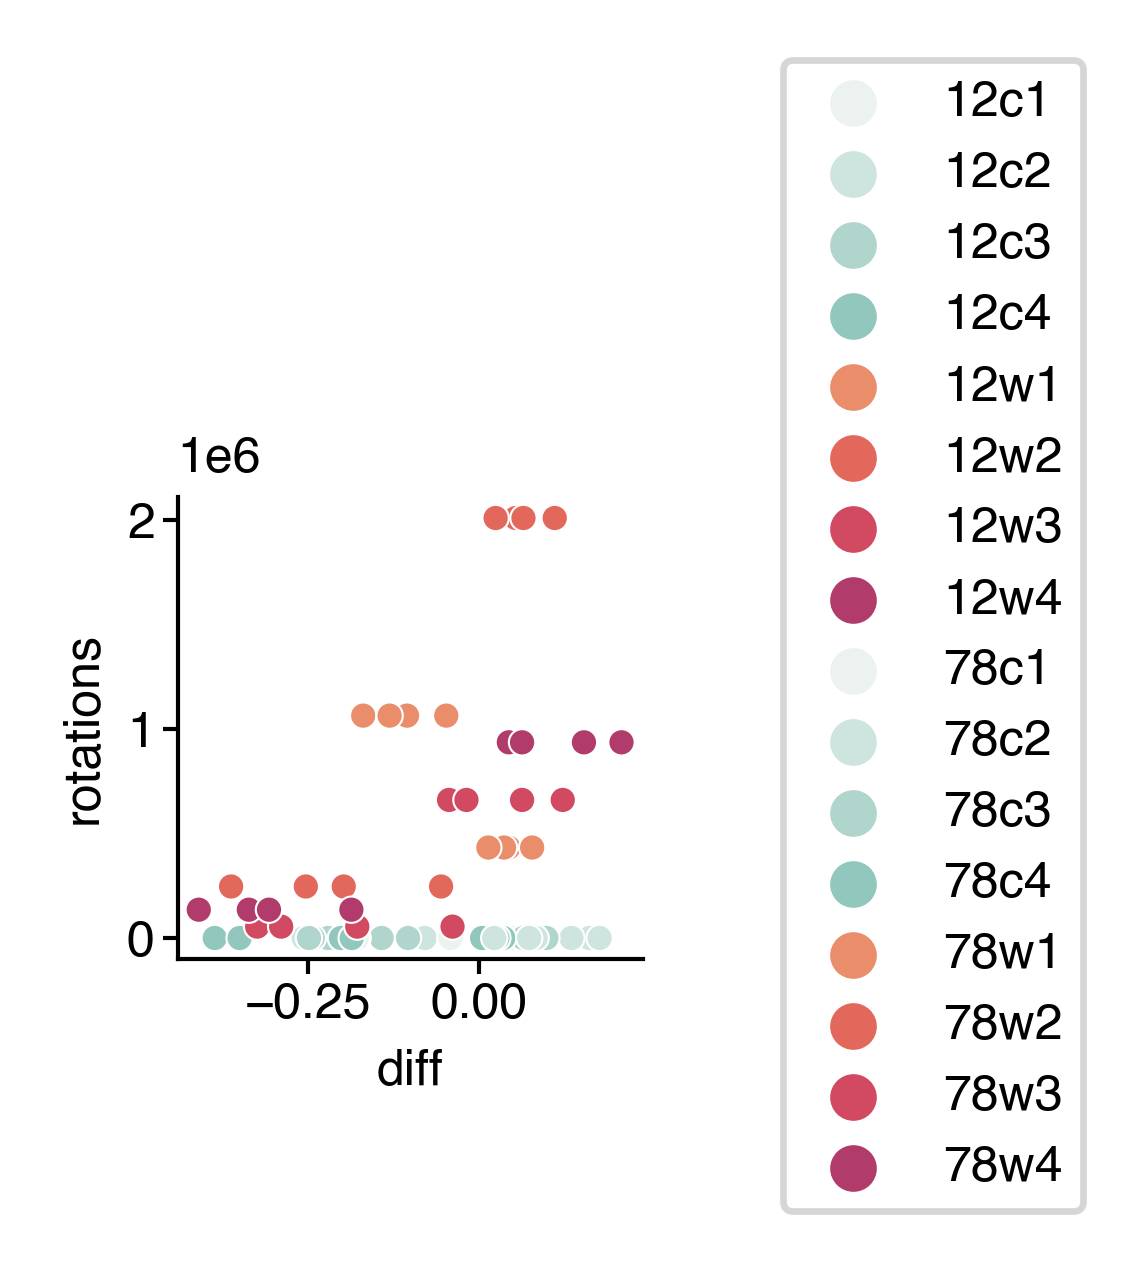

In [23]:
figure(1,1)
sns.scatterplot(
    data=psd_diff, 
    x='diff', 
    hue='cage',
    s=10,
    palette = ['#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c','#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c'],
    y='rotations'
)
plt.legend(loc='upper right', bbox_to_anchor=(2, 2))
sns.despine()

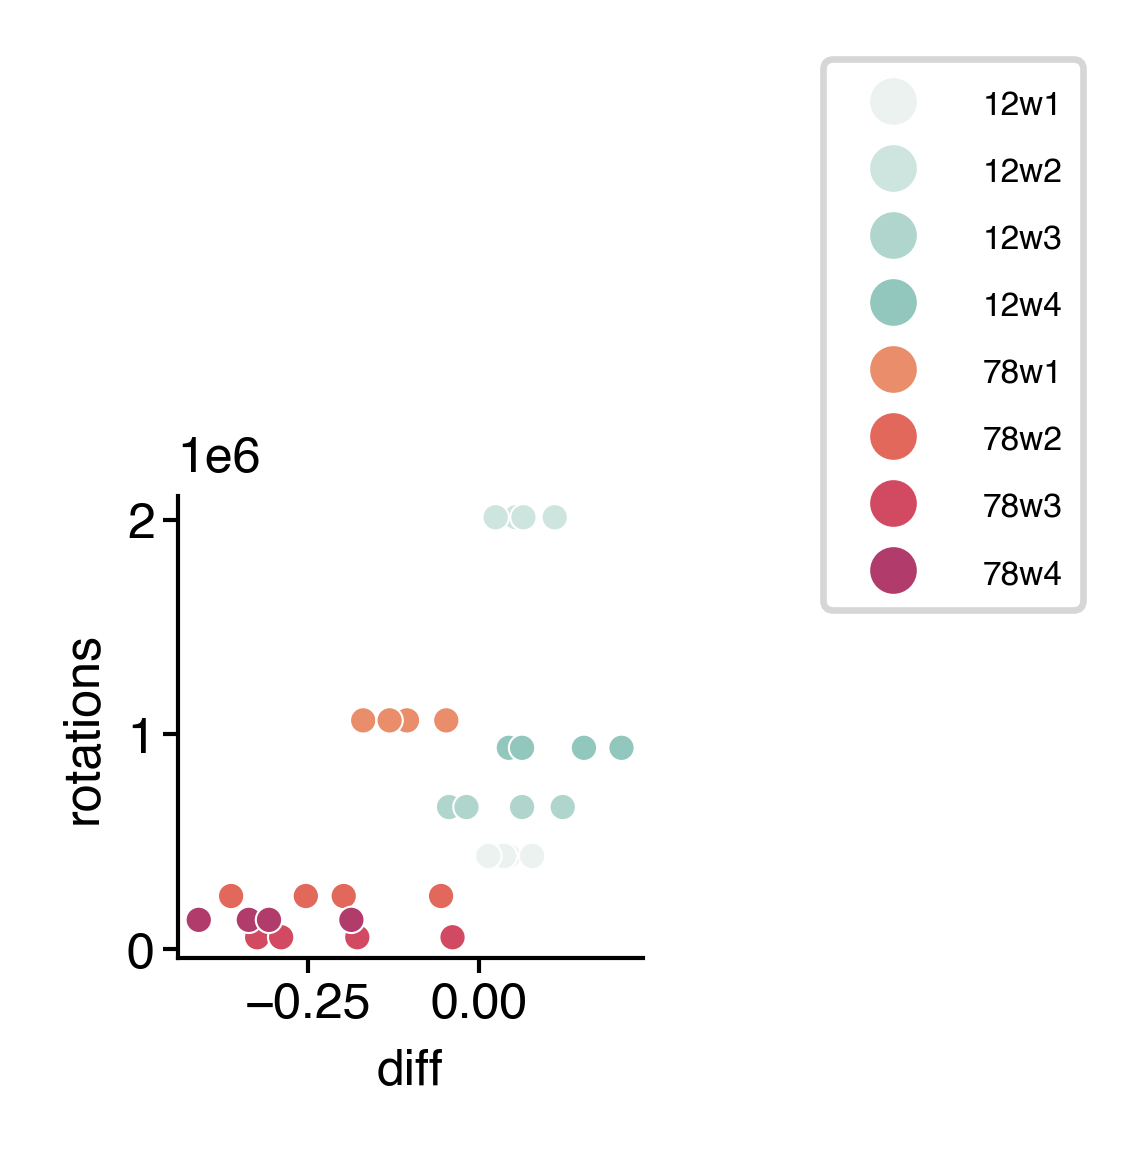

In [24]:
from matplotlib.font_manager import FontProperties
figure(1,1)
sns.scatterplot(
    data=psd_diff.query("exp=='12w' or exp=='78w'"), 
    x='diff', 
    hue='cage',
    s=10,
    palette = ['#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c'],
    y='rotations'
)
legend=plt.legend(loc='upper right', bbox_to_anchor=(2, 2))
# Set the font properties for the legend
font_props = FontProperties()
font_props.set_size('4')  # Set the font size
font_props.set_family('sans-serif')  # Set the font family (e.g., 'serif', 'sans-serif', etc.)

# Apply the font properties to the legend
for text in legend.texts:
    text.set_font_properties(font_props)
    
sns.despine()

## V2 of the wheel regression

In [25]:
pseudo_cuts = pd.qcut(
    df_male["pseudotime_rank"],
    df_male.index.get_level_values("age").nunique(),
    labels=False,
)

In [26]:
enc = LabelEncoder().fit(df_male.index.get_level_values('age'))
age_cuts = enc.transform(df_male.index.get_level_values('age'))

In [27]:
pseudo_mapped = enc.inverse_transform(pseudo_cuts)

In [28]:
def zscore(df):
    return (df - df.mean()) / df.std()

In [29]:
# pseudo regression
# mdl = PLSRegression(n_components=3)
mdl = ElasticNet(l1_ratio=0.9, alpha=3e-1)
# y = np.log(pseudo_mapped)
y = np.log(df_male.index.get_level_values('age'))
x = zscore(df_male.filter(regex=r'\d'))
mdl.fit(x, y)
print(mdl.score(x, y))

0.7884602161831034


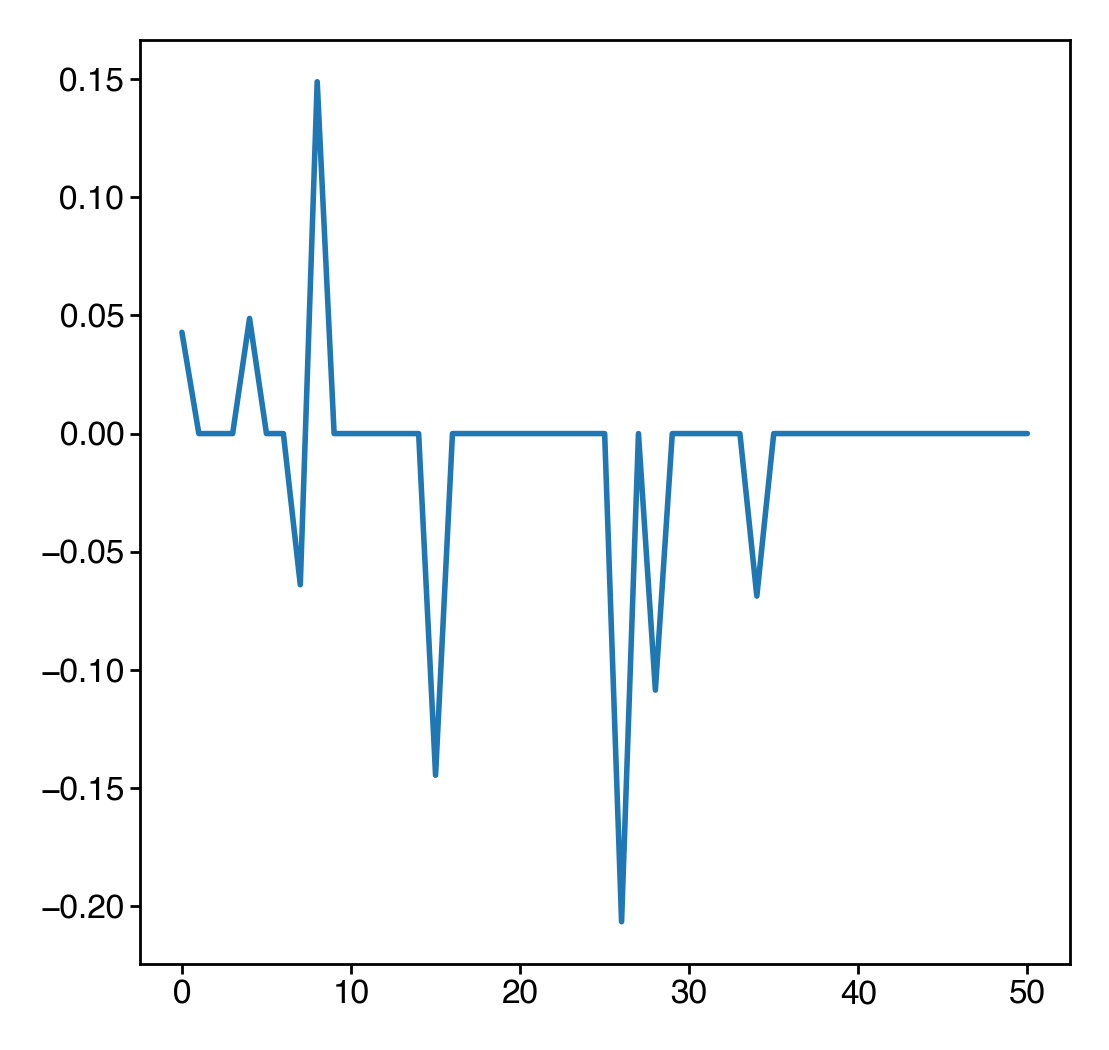

In [30]:
# plt.plot(sorted(np.abs(mdl.coef_.squeeze())))
plt.plot(mdl.coef_.squeeze())

In [31]:
np.where(mdl.coef_.squeeze() != 0)[0]

array([ 0,  4,  7,  8, 15, 26, 28, 34])

In [32]:
x = df.filter(regex=r"\d")
df["psd"] = mdl.predict(
    zscore(x.reindex(columns=df_male.filter(regex=r"\d").columns).fillna(0) + 1e-6)
)

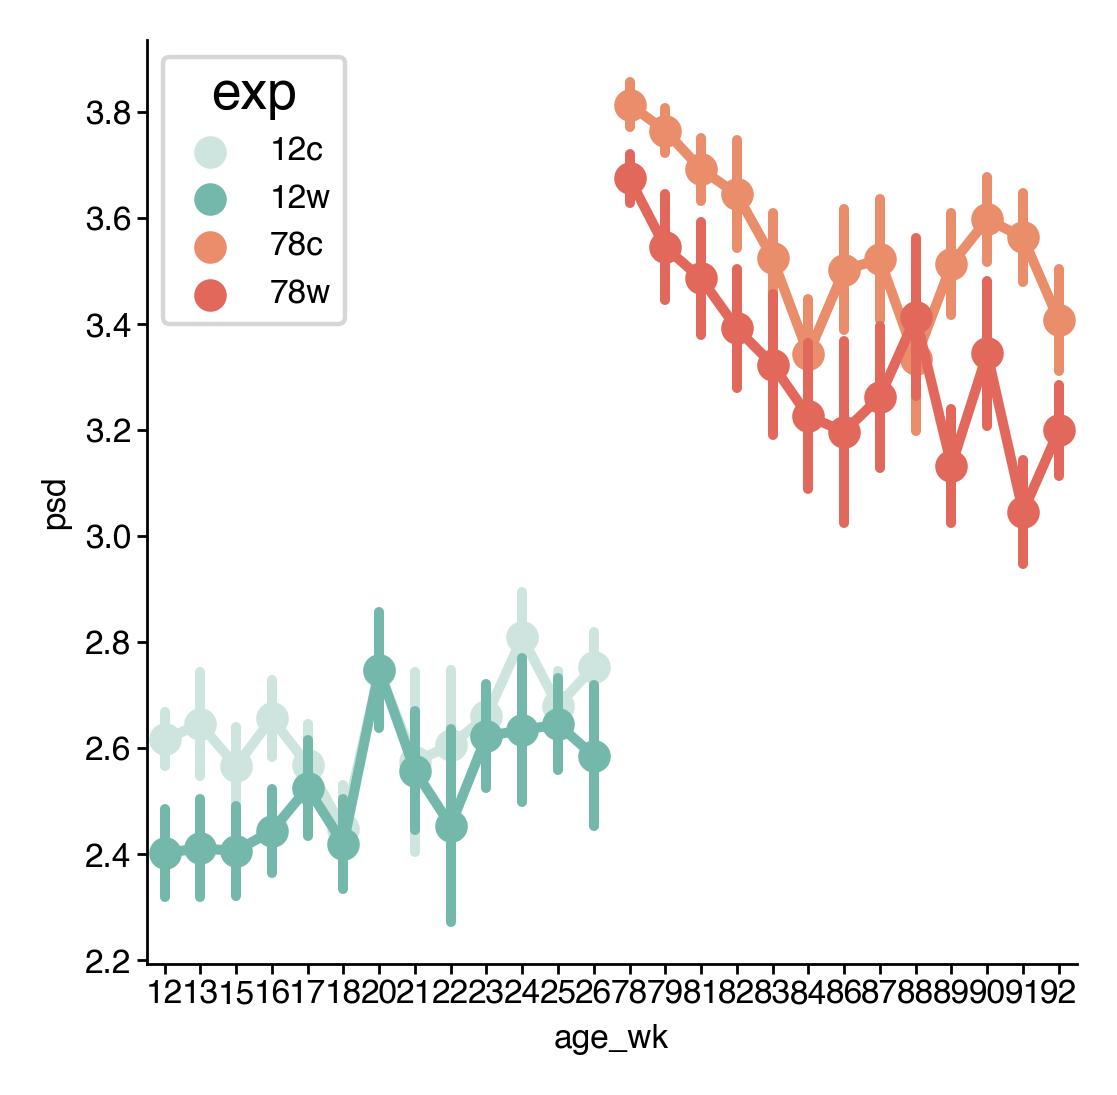

In [33]:
sns.pointplot(
    data=df,
    x="age_wk",
    y="psd",
    palette=["#cde4df", "#73b8aa", "#e98d6b", "#e3685c"],
    estimator="mean",
    errorbar="se",
    hue="exp",
)
sns.despine()

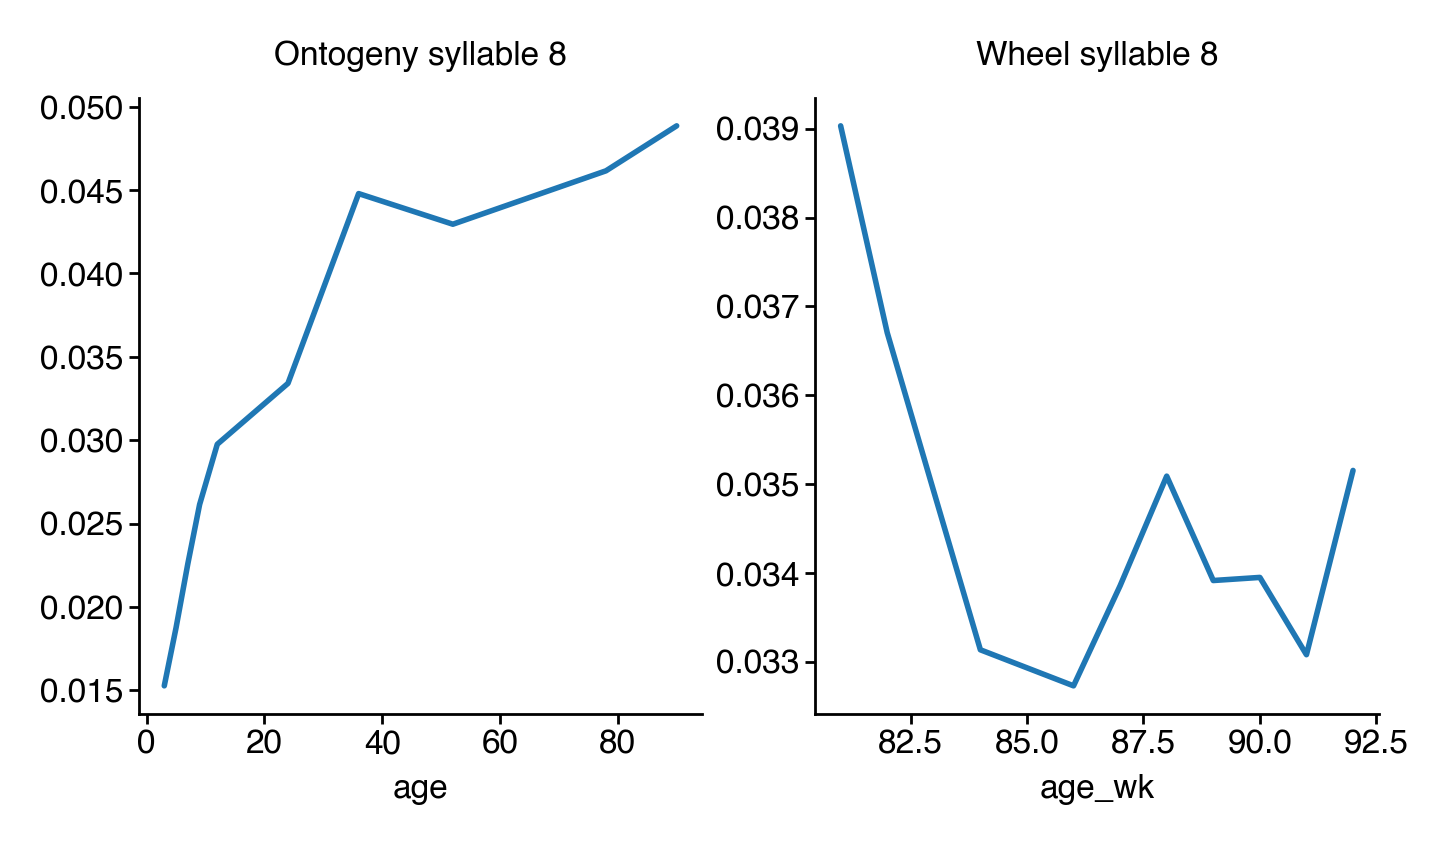

In [49]:
syll = 8
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
df_male.groupby("age").mean()[f"{syll}"].plot(ax=ax[0])
ax[0].set_title(f"Ontogeny syllable {syll}")
df[df["cage"].str.contains("c")].query("age > 420").groupby("age_wk")[f"{syll}"].mean().rolling(
    3
).mean().plot(ax=ax[1])
ax[1].set_title(f"Wheel syllable {syll}")
sns.despine()

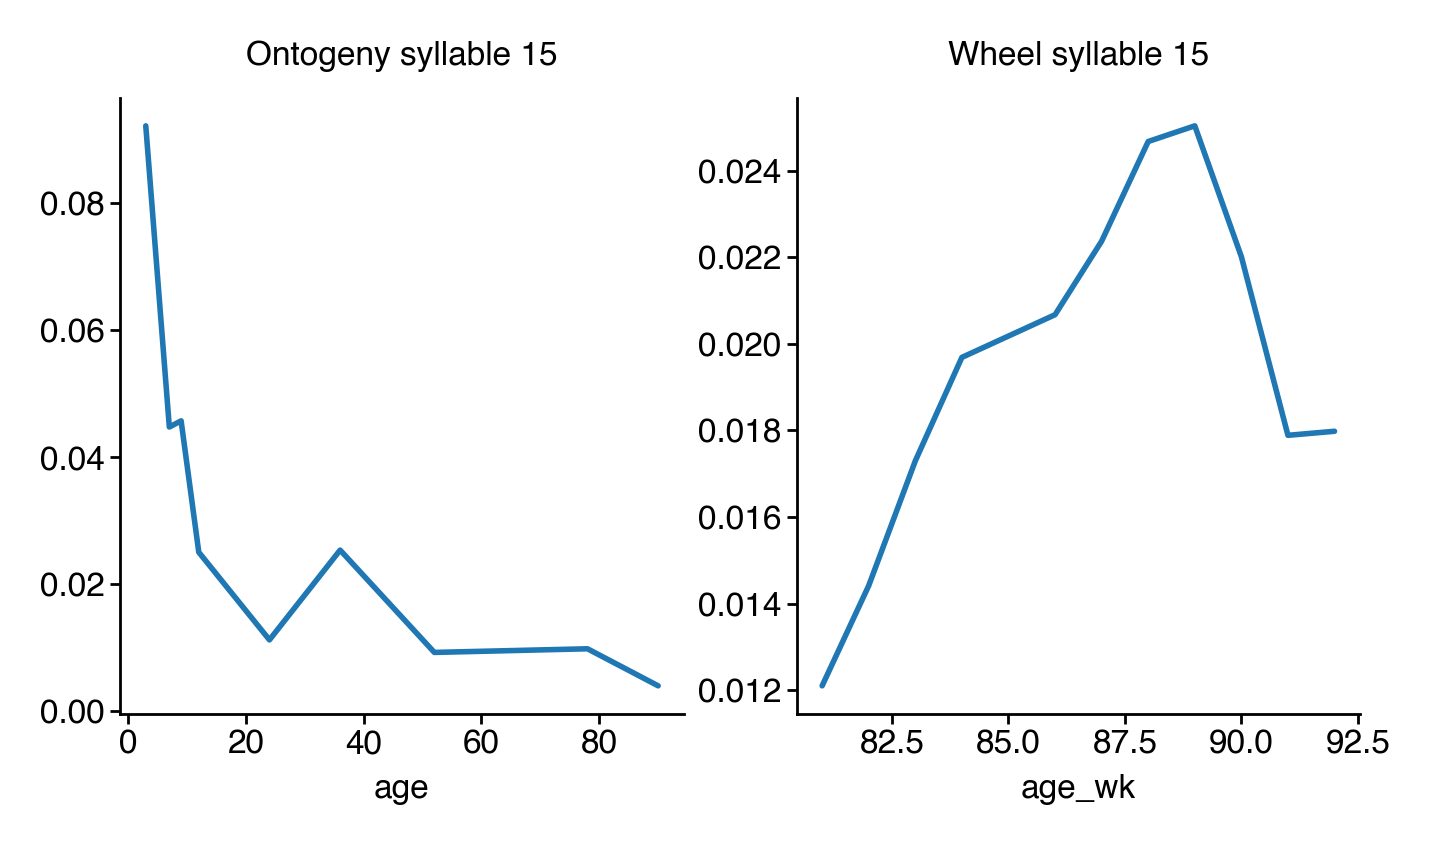

In [50]:
syll = 15
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
df_male.groupby("age").mean()[f"{syll}"].plot(ax=ax[0])
ax[0].set_title(f"Ontogeny syllable {syll}")
df[df["cage"].str.contains("c")].query("age > 420").groupby("age_wk")[f"{syll}"].mean().rolling(
    3
).mean().plot(ax=ax[1])
ax[1].set_title(f"Wheel syllable {syll}")
sns.despine()

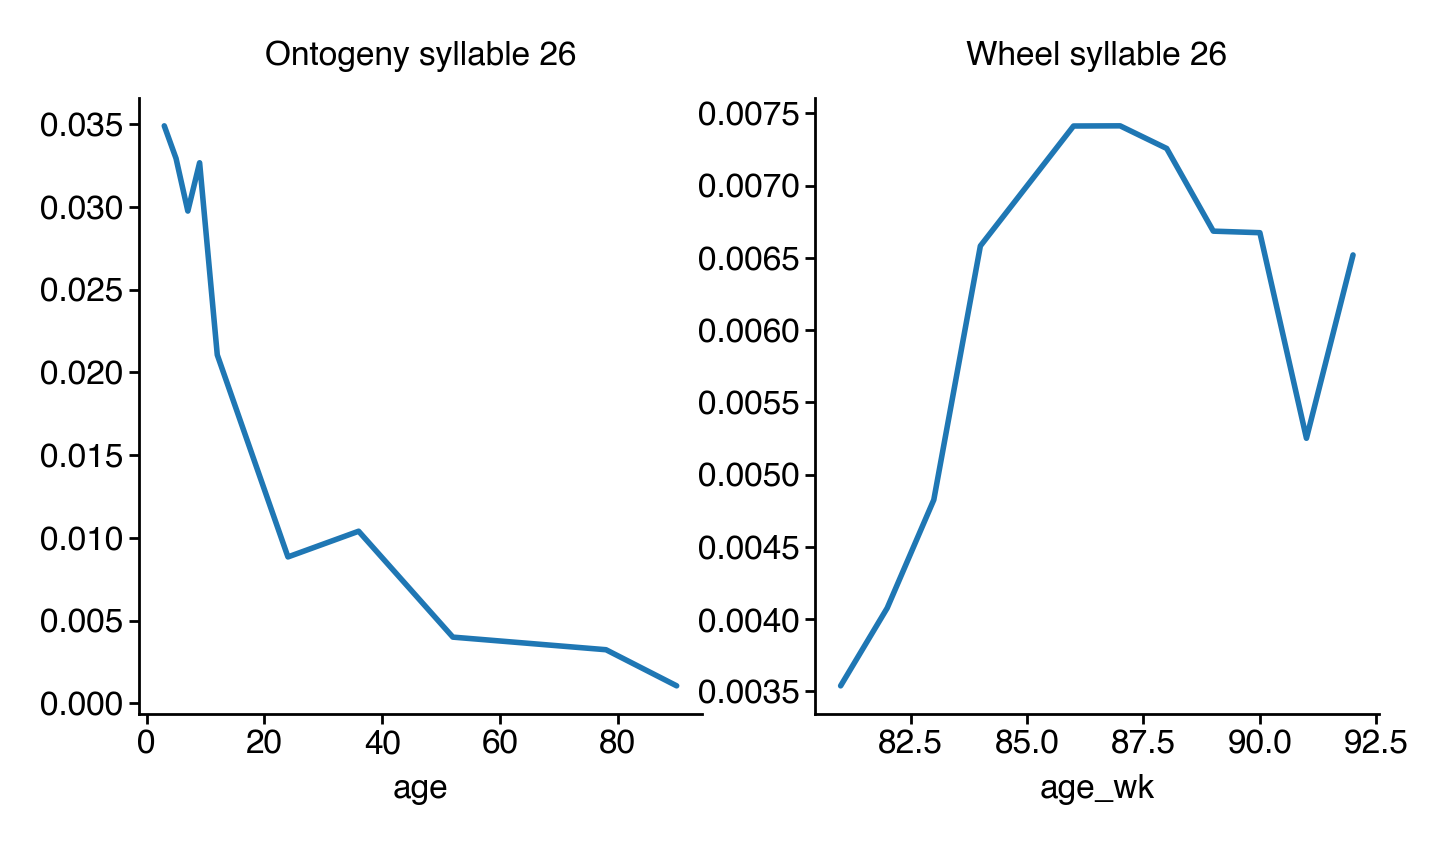

In [51]:
syll = 26
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
df_male.groupby("age").mean()[f"{syll}"].plot(ax=ax[0])
ax[0].set_title(f"Ontogeny syllable {syll}")
df[df["cage"].str.contains("c")].query("age > 420").groupby("age_wk")[f"{syll}"].mean().rolling(
    3
).mean().plot(ax=ax[1])
ax[1].set_title(f"Wheel syllable {syll}")
sns.despine()

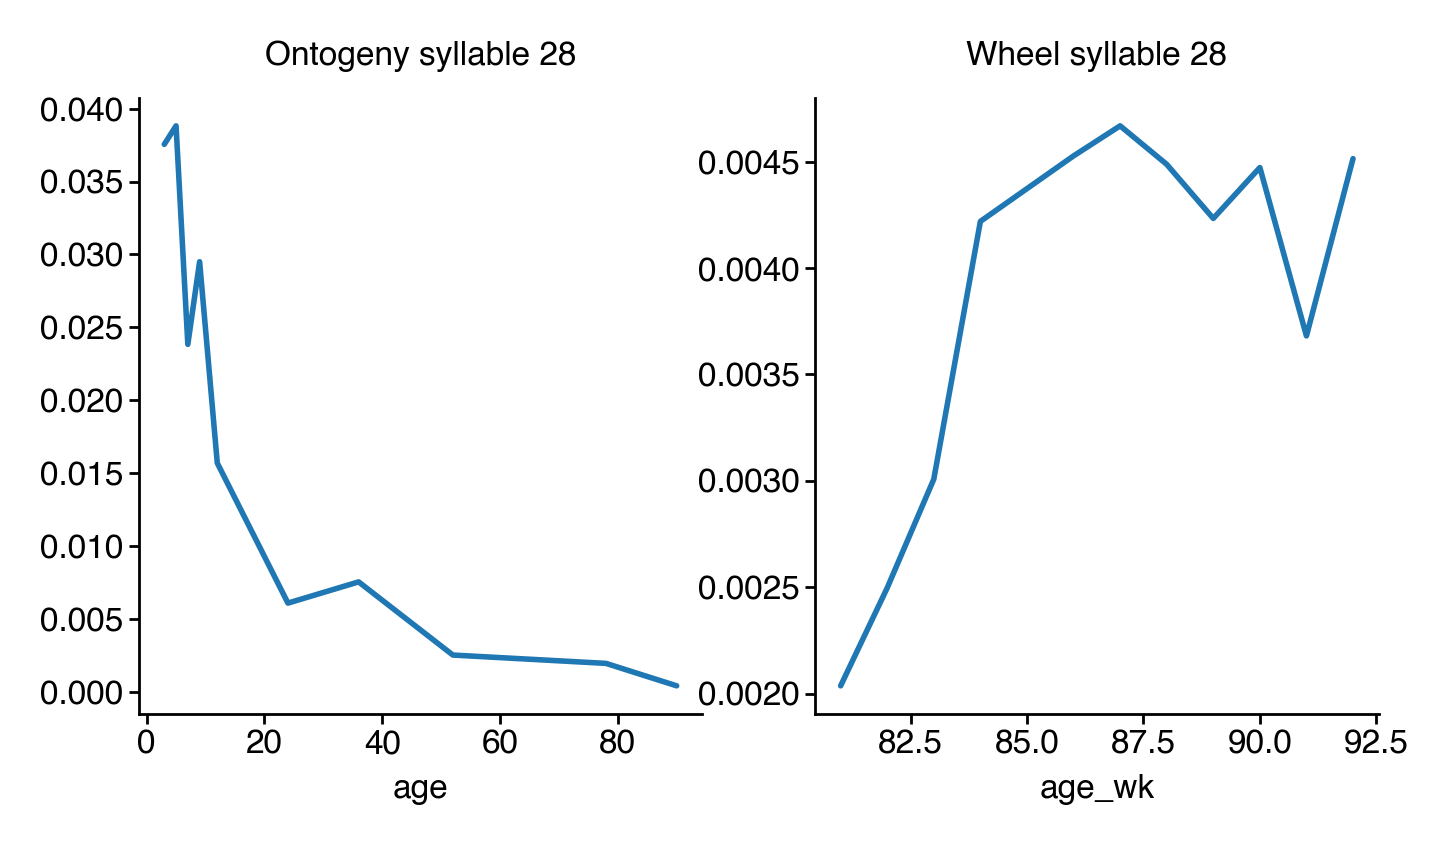

In [52]:
syll = 28
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
df_male.groupby("age").mean()[f"{syll}"].plot(ax=ax[0])
ax[0].set_title(f"Ontogeny syllable {syll}")
df[df["cage"].str.contains("c")].query("age > 420").groupby("age_wk")[f"{syll}"].mean().rolling(
    3
).mean().plot(ax=ax[1])
ax[1].set_title(f"Wheel syllable {syll}")
sns.despine()

## Train regressor on just 78wk wheel data

- does not work at all

In [89]:
# pseudo regression
tmp = df.query('age > 420')
tmp = tmp[tmp['cage'].str.contains('c')]
mdl = PLSRegression(n_components=3)
y = tmp['age_wk']
ss = StandardScaler()
x = ss.fit_transform(tmp.filter(regex=r'\d'))
mdl.fit(x, y)
print(mdl.score(x, y))

0.5686497053860766


In [90]:
df["psd"] = mdl.predict(ss.transform(df.filter(regex=r'\d')))

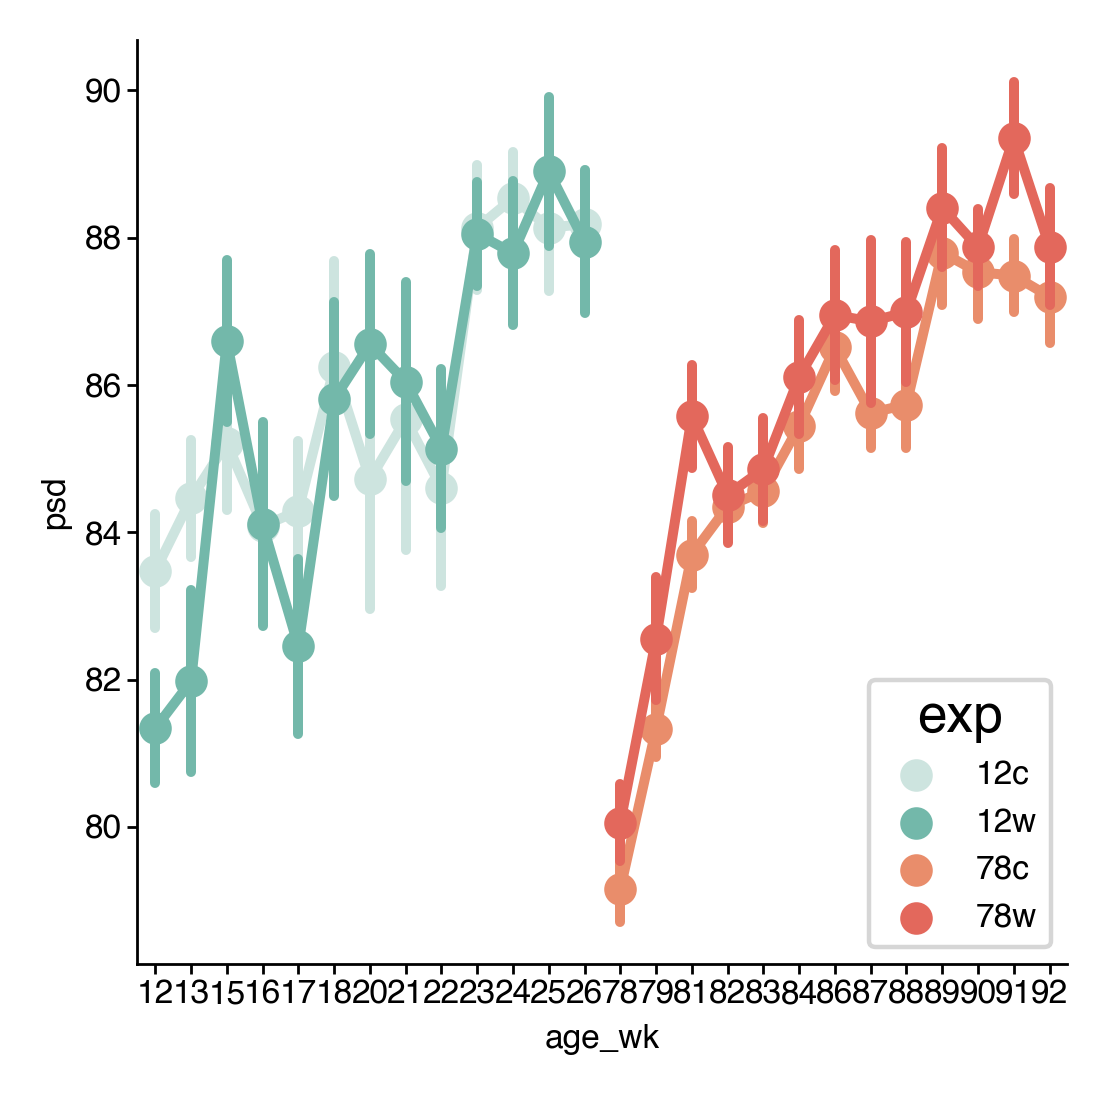

In [91]:
sns.pointplot(
    data=df,
    x="age_wk",
    y="psd",
    palette=["#cde4df", "#73b8aa", "#e98d6b", "#e3685c"],
    estimator="mean",
    errorbar="se",
    hue="exp",
)
sns.despine()